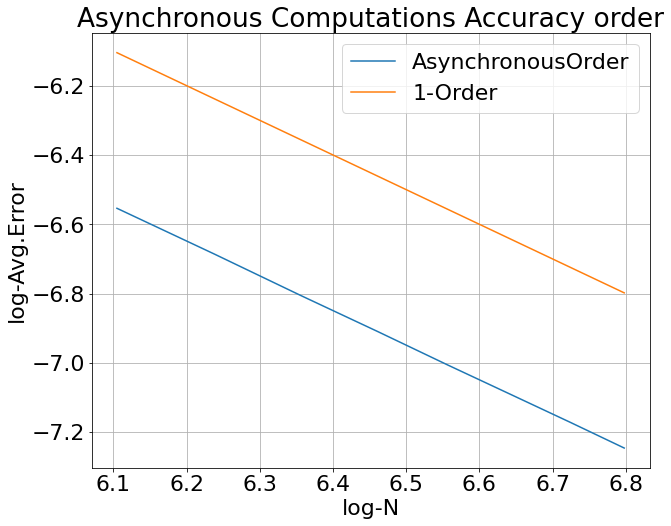

In [1]:
''' First restart jupyter kernel
Then, in FLAG_file, set SyncFLAG ='DAsync' '''
def Async_sim(num_grid):
    import delay_file
    import probability_initial
    import error_file
    import analytical_file
    import ic_file
    import numpy as np
    import matplotlib.pyplot as plt
    import timestep_file
    import FLAG_file
    import grid_file
    import input_file
    import step

    ## This cell remains same for Asynchronous compute ##
    Length=2*np.pi
    nx_=num_grid
    dx=Length/(nx_-1)
    x_=grid_file.grid_(dx,nx_)
    C=input_file.c
    init_c=ic_file.ic_(x_,amp=input_file.amp_ls,kappa=input_file.k_ls,phi=input_file.phi_ls,
                       num_k=input_file.numk,num_phi=input_file.numphi,Nx=nx_)
    dt=timestep_file.timestep_(dx,cfl=input_file.cfl,EqFLAG=FLAG_file.EqnFLAG,cx=input_file.c)
    Nt=input_file.N_t_
    arr_2d=[]
    # Nt=input_file.N_t_
    L=3
    u=init_c
    arr_2d.append(u)
    for k in range(L-1):
        rhs=step.cd2u1(u,C,dx,nx_,Eqflag=FLAG_file.EqnFLAG,Syncflag='DSync')
        u=step.euler(u,rhs,dt,nx_)
        arr_2d.append(u)
    arr_2d=np.stack(arr_2d)

    num_PEs=input_file.numPE
    per_PEs=int((nx_)/(num_PEs))
    ps_i,pe_i=probability_initial.prob_2D_from_arr_2D(arr_2d[:-1],num_PEs,per_PEs,L-1)
    u=arr_2d[L-1]
    ls=[]
    ls.append(u)
    ps=ps_i
    pe=pe_i
    for j in range(Nt):
        ys,ye=probability_initial.prob_1D_from_u_1D(u,num_PEs,per_PEs)
        ps=np.vstack((ps,ys))
        pe=np.vstack((pe,ye))
        rhs,ps,pe=step.cd2u1(u,C,dx,nx_,Eqflag=FLAG_file.EqnFLAG,Syncflag=FLAG_file.SyncFLAG,L=3,PE=num_PEs,perPE=per_PEs,
                             pstart=ps,pend=pe)       
        u=step.euler(u,rhs,dt,nx_)
        ls.append(u)        
    Nt_total=Nt+L-1
#     for i in range(40):
#         plt.plot(x_,ls[i*7])
    ana_soln=analytical_file.analytical_(x_,input_file.amp_ls,input_file.k_ls,input_file.phi_ls,input_file.numk,
                                    input_file.numphi,nx_,dt*Nt,C,0)
    error_Nx=error_file.error_MSE_(ana_soln,ls[-1])
    return error_Nx,np.vstack((arr_2d,ls[1:]))

import matplotlib.pyplot as plt
import numpy as np
import plotAccuracyOrder
nx_list=64*np.arange(7,15)
err=[Async_sim(n)[0] for n in nx_list]
plotAccuracyOrder.plot_error(nx_list,err,'Asynchronous',1)

import input_file
num_X=input_file.Nx
Async_FD_data=Async_sim(num_X)[1]
np.savetxt('Async'+f'{num_X}',Async_FD_data)